### What is ARIMA:
ARIMA stands for Autoregressive Integrated Moving Average. It is an algorithm used for forecasting Time Series Data. ARIMA models have three parameters like ARIMA(p, d, q).  

1. **p** is the number of lagged values that need to be added or subtracted from the values (label column). It captures the autoregressive part of ARIMA.
2. **d** represents the number of times the data needs to differentiate to produce a stationary signal. If it’s stationary data, the value of d should be 0, and if it’s seasonal data, the value of d should be 1. d captures the integrated part of ARIMA.
3. **q** is the number of lagged values for the error term added or subtracted from the values (label column). It captures the moving average part of ARIMA.

In [11]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
today = date.today()
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = today - timedelta(days=365)
start_date = d2

print("Start Date", start_date, "End Date", end_date)

Start Date 2023-12-25 End Date 2024-12-24


In [5]:
# Collecting Google Stock Price using Yahoo Finance API
dataset = yf.download('GOOG',
                      start=start_date,
                      end=end_date, 
                      progress=False)

In [6]:
dataset.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2023-12-26,142.308670,142.820007,143.945007,142.500000,142.979996,11170100
2023-12-27,140.933624,141.440002,143.320007,141.050995,142.830002,17288400
2023-12-28,140.774185,141.279999,142.270004,140.828003,141.850006,12192500
2023-12-29,140.425446,140.929993,141.434998,139.899994,140.679993,14872700
2024-01-02,139.060333,139.559998,140.615005,137.740005,139.600006,20071900


In [7]:
dataset['Date'] = dataset.index
dataset = dataset[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
dataset.reset_index(drop=True, inplace=True)

In [9]:
print(dataset.head())

Price        Date        Open        High         Low       Close   Adj Close  \
Ticker                   GOOG        GOOG        GOOG        GOOG        GOOG   
0      2023-12-26  142.979996  143.945007  142.500000  142.820007  142.308670   
1      2023-12-27  142.830002  143.320007  141.050995  141.440002  140.933624   
2      2023-12-28  141.850006  142.270004  140.828003  141.279999  140.774185   
3      2023-12-29  140.679993  141.434998  139.899994  140.929993  140.425446   
4      2024-01-02  139.600006  140.615005  137.740005  139.559998  139.060333   

Price     Volume  
Ticker      GOOG  
0       11170100  
1       17288400  
2       12192500  
3       14872700  
4       20071900  


In [10]:
dataset = dataset[['Date', 'Close']]
print(dataset.head())

Price        Date       Close
Ticker                   GOOG
0      2023-12-26  142.820007
1      2023-12-27  141.440002
2      2023-12-28  141.279999
3      2023-12-29  140.929993
4      2024-01-02  139.559998


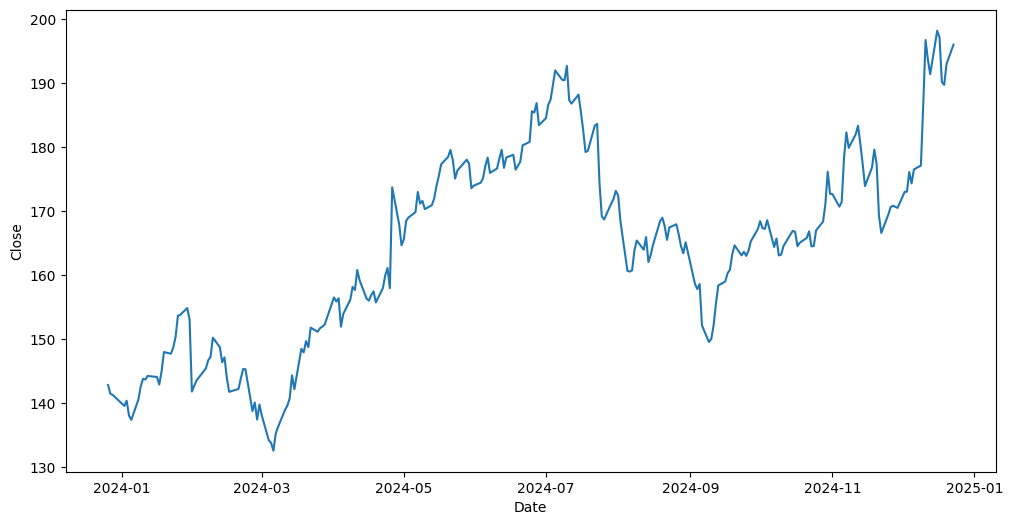

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(dataset["Date"], dataset["Close"])
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

> The data visualization graph about the closing stock prices above shows that our dataset is not stationary. Trends and changing levels in the graph rules out the dataset as a stationary one!

To check whether our dataset is stationary or seasonal properly, we can use the seasonal decomposition method that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data:

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataset['Close'], model='multiplicative', period=30)

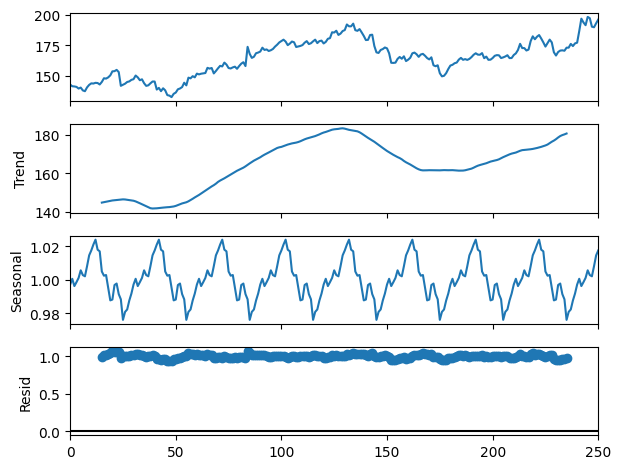

In [19]:
# Plot the decomposed components
result.plot()
plt.show()

> The dataset is not stationary, it is seasonal! We need to use the Seasonal ARIMA **(SARIMA)** model for Time Series Forecasting on this data. 